# Modèles de prédiction 

Je propose de résumer ici le travail d'exploration fait dans le premier notebook. 

L'objectif est de prédire deux variables numériques : la consommation d'énergie des bâtiments ```SiteEnergyUse(kBtu)```et la quantité d'émission de CO2 ```CO2_emissions```. Après différents pré-traitements tels que l'élimination des variables corrélées entres elles, ou la vectorisation des variables catégorielles, le jeu d'entrainement a la forme suivante : 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_path = "/home/clairegayral/Documents/openclassroom/data/P3/"
res_path = "/home/clairegayral/Documents/openclassroom/res/P3/"

## my .py : 
from P3_preprocess import *
import missing_values_treatment
import duplicates
import univariate_analysis
import multivariate_analysis

from sklearn import model_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.impute import KNNImputer
from sklearn import linear_model


In [2]:
data = pd.read_csv(res_path+"cleanned_data.csv", index_col=0)
print(len(data.columns[data.dtypes==float])-3, "training numerical variables")
print(len(data.columns[data.dtypes==int]), 
      "training interger variables (from tokenization of categorical variable)")
data.head()

6 training numerical variables
22 training interger variables (from tokenization of categorical variable)


,ZipCode,NumberofBuildings,NumberofFloors,PropertyGFAParking,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),CO2_emissions,age_of_building,BuildingType_0,...,LargestPropertyUseType_2,LargestPropertyUseType_3,LargestPropertyUseType_4,LargestPropertyUseType_5,LargestPropertyUseType_6,LargestPropertyUseType_7,LargestPropertyUseType_8,LargestPropertyUseType_9,LargestPropertyUseType_10,LargestPropertyUseType_11
0,58091.0,1.0,12.0,0.0,88434.0,62.5,7103895.25,249.705,88.5,0,...,0,0,0,0,0,0,0,0,0,1
1,58091.0,1.0,11.0,15064.0,83880.0,56.0,8371084.00,279.685,19.5,0,...,0,0,0,0,0,0,0,0,0,1
2,58091.0,1.0,41.0,98359.0,756868.0,30.5,72858840.00,2075.380,46.5,0,...,0,0,0,0,0,0,0,0,0,1
3,58091.0,1.0,10.0,0.0,61320.0,28.5,17511952.00,1111.385,89.5,0,...,0,0,0,0,0,0,0,0,0,1
4,58848.5,1.0,18.0,37230.0,123445.0,71.0,14500852.50,506.355,35.5,0,...,0,0,0,0,0,0,0,0,0,1


# Mise à l'écart de l'ensemble de test : 
Je mets de côté l'ensemble de test, sur lequel je comparerai mes modèles prédictifs à la fin. 

### Séparation données d'entrainement

In [3]:
from sklearn.model_selection import train_test_split

X_original = data.drop(["SiteEnergyUse(kBtu)","CO2_emissions", "ENERGYSTARScore"], axis = 1)
y_original = data[["SiteEnergyUse(kBtu)","CO2_emissions"]]

X_original_train, X_original_test, y_original_train, y_original_test = train_test_split(X_original, y_original, train_size=0.8)

index_train = y_original_train.index
index_test = y_original_test.index

Par soucis de clarté de code, je vais renommer $X\_original\_train$ avec $X$. **Ainsi, le lecteur pourra bien comprendre que le $X$ évoqué dans la suite sera bien l'ensemble d'entrainement.**

In [4]:
X = X_original_train
y = y_original_train

### Standardisation entrainée sur l'ensemble d'entrainement

In [136]:
from sklearn import preprocessing
my_standardizer = preprocessing.StandardScaler()
my_standardizer.fit(X_original_train)

X_std = pd.DataFrame(my_standardizer.transform(X), columns=X.columns, index = X.index)
X_original_test_std = my_standardizer.transform(X_original_test)

## std y ?
my_standardizer.fit(y_original_train)

y_std = pd.DataFrame(my_standardizer.transform(y), columns = y.columns, index = y.index)
y_original_test_std = my_standardizer.transform(y_original_test)

In [137]:
from multivariate_analysis import *
from sklearn.model_selection import RepeatedKFold

X_ = X_std.copy()
y_ = y_std["SiteEnergyUse(kBtu)"].copy()
my_meth = linear_model.LinearRegression(fit_intercept = True,normalize = True)
cv = 5
def pseudo_cv_without_paramgrid(X_, y_, my_meth, cv = 5):
    ## init
    k = 1
    res = {} # dict of dict 
    kf = RepeatedKFold(n_splits = cv, n_repeats=1)
    ## loop on folds
    for train_range_index, test_range_index in kf.split(X = X_.values, y = y_.values) : 
        train_index = y_.index[train_range_index].values
        test_index = y_.index[test_range_index].values

        ## GET X and y SPLIT : 
        CV_X_train, CV_X_test = X_.loc[train_index,:], X_.loc[test_index,:]
        CV_y_train, CV_y_test = y_.loc[train_index], y_.loc[test_index]

        fold_key = "fold"+str(k)
        k+=1

        my_meth.fit(CV_X_train,CV_y_train) 
        y_pred = my_meth.predict(CV_X_test)
        y_table = pd.DataFrame(np.matrix((y_pred, CV_y_test)).T, columns=["pred","real"])
        res[fold_key] = y_table
    return(res)

from sklearn import metrics
def compute_R2(table):
    return(metrics.r2_score(y_true = table.real, y_pred=table.pred))

def get_score_from_pseudo_CV(dict_y_table, cv = 5):
    score = []
#     dict_y_table = pseudo_cv_without_paramgrid(X_, y_, my_meth, cv = 5)
    for y_table in dict_y_table.values():
        score.append(compute_R2(y_table))
    return(score)

10000.0


,score,execution_time,best_alpha
lr,-1720516091232368450379014209536.0,0.015241,None
ridge,0.294408,0.260835,908.517576
enet,0.129288,0.279276,0.068129


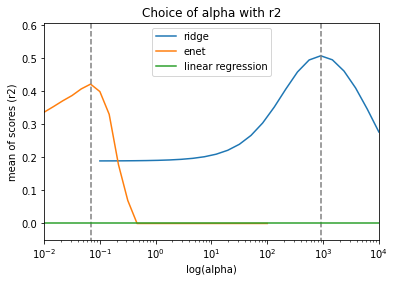

In [135]:
dict_param_grid = {"ridge": np.logspace(-1, 4, 25),
                   "lasso": np.logspace(-1, 2, 25),
                   "enet" : np.logspace(-2, 2, 25),
                  }

dict_models = {"ridge" : linear_model.Ridge(), 
#                "lasso" : linear_model.Lasso(),
               "enet" : linear_model.ElasticNet(),
              }
    
compare_regressions2(X_std, np.log(y_+1), dict_models, dict_param_grid, score_name="r2", fig_name=None)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f19520a9790>,
 'caps': [<matplotlib.lines.Line2D at 0x7f19520a9eb0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f19520a9400>],
 'medians': [<matplotlib.lines.Line2D at 0x7f19520b3610>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f19520b39a0>],
 'means': []}

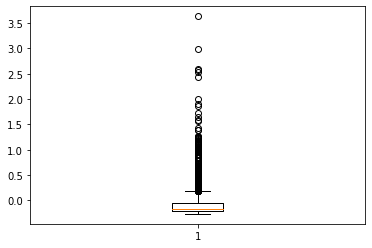

In [115]:
plt.boxplot(np.log(y_+1))